# 简介

聚合一组预测器（比如分类器或回归器）的预测，得到的预测结果也比最好的单个预测器要好，这样的一组预测器，我们称为集成，这种技术也被称为集成学习，而一个集成学习的算法则被称为集成方法。  

常用的集成学习方法：

* Voting（投票）
* Bagging  
    * 随机森林
* Boosting
    * AdaBoost
    * 提升树
    * XGboost
* stacking

# Voting

假设创建了一个包含1000个分类器的集成，每个分类器都只有51%的几率是正确的（几乎没比随机猜测强多少）。如果以大多数投票的类别作为预测结果，则准确率可达75%。如果有10000个分类器，则准确率可以高达97%。  

但是，上述的前提是：所有的分类器都是完全独立的，彼此的错误毫不相关。显然这是不可能的，因为它们都是在相同的数据上训练的。它们很可能会犯相同的错误，所以也会有很多次大多数投给了错误的类别，导致集成的准确率有所降低。

## 原理

<img src="img/硬投票.png" width="600">

* 硬投票分类器：直接以大多数投票的类别作为预测结果，称为硬投票法。
* 软投票分类器：如果所有分类器都能够估算出类别的概率，那么可以将概率在所有单个分类器上平均，然后让给出平均概率最高的类别作为预测。
* 通常来说，软投票法比硬投票法的表现更优，因为它给予那些高度自信的投票更高的权重。

## 代码实现

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

**使用sklearn中的moon数据集**

In [2]:
X,y = make_moons(n_samples=7000,noise=0.1)

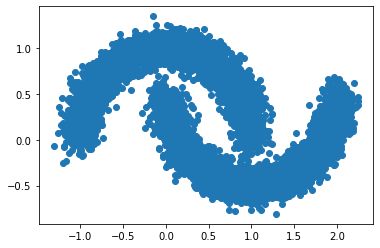

In [3]:
plt.scatter(X[:,0],X[:,1])

**数据集分割**

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

**定义三个基分类器**  
* 逻辑回归
* 决策树
* SVM

In [5]:
lr = LogisticRegression()
dt = DecisionTreeClassifier()
svm = SVC()
# 软投票分类器需要输出概率值
# svm = SVC(probability=True)

**定义投票分类器**

In [6]:
voting = VotingClassifier(
    estimators=[('lr',lr),('dt',dt),('svm',svm)],
    voting='hard'   # hard-硬投票,soft-软投票
)

**输出各个分类器的准确率**

In [7]:
for clf in (lr,dt,svm,voting):
    clf.fit(X_train,y_train)
    y_hat = clf.predict(X_test)
    print(clf.__class__.__name__,'=',accuracy_score(y_test,y_hat))

LogisticRegression = 0.8845714285714286
DecisionTreeClassifier = 0.9988571428571429
SVC = 0.9994285714285714
VotingClassifier = 0.9994285714285714


# Bagging

每个预测器使用的算法相同，但是在不同的训练集随机子集上进行训练。采样时如果将样本放回，这种方法叫作**bagging**（bootstrap aggregating，自举汇聚法）。采样时样本不放回，这种方法则叫作**pasting**。

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import load_iris

In [9]:
iris = load_iris()
X = iris.data
y = iris.target

In [10]:
bag_clf = BaggingClassifier(
    SVC(),                 # 指定基分类器
    n_estimators=500,      # 500个基分类器
    bootstrap=True,        # bootstrap=True为bagging，bootstrap=False为pasting
    max_samples=20         # max_samples设置为整数表示的就是采样的样本数，设置为浮点数表示的是max_samples*x.shape[0]
)

In [11]:
bag_clf.fit(X,y)
y_hat = bag_clf.predict(X)
print(bag_clf.__class__.__name__,'=',accuracy_score(y,y_hat))

BaggingClassifier = 0.9533333333333334


In [12]:
bag_clf = BaggingClassifier(
    SVC(),                 # 指定基分类器
    n_estimators=500,      # 500个基分类器
    bootstrap=True,        # bootstrap=True为bagging，bootstrap=False为pasting
    max_samples=20,        # max_samples设置为整数表示的就是采样的样本数，设置为浮点数表示的是max_samples*x.shape[0]
    oob_score=True         # 用从没抽到过的样本作为测试集
)

In [13]:
bag_clf.fit(X,y)
print(bag_clf.oob_score_)

0.9333333333333333


## 随机森林

随机森林是决策树的集成，通常用bagging（有时也可能是pasting）方法训练。除了先构建一个BaggingClassifier然后将结果传输到DecisionTreeClassifier，
还有一种方法就是使用RandomForestClassifier类。

In [14]:
# 如果基分类器是决策树，那么就是随机森林
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),                 
    n_estimators=500,      
    bootstrap=True,        
    max_samples=1.0
)

In [15]:
bag_clf.fit(X,y)
y_hat = bag_clf.predict(X)
print(bag_clf.__class__.__name__,'=',accuracy_score(y,y_hat))

BaggingClassifier = 1.0


In [16]:
# Sklearn也提供了直接实现随机森林的API
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500)
rnd_clf.fit(X,y)
y_hat = rnd_clf.predict(X)
print(rnd_clf.__class__.__name__,'=',accuracy_score(y,y_hat))

RandomForestClassifier = 1.0


# Boosting

可以将几个弱学习器结合成一个强学习器的集成方法。大多数提升法的总体思路是循环训练预测器，每一次都对其前序做出一些改正。
* AdaBoost
* GBDT
* XGBoost

## AdaBoost

从弱学习算法出发，反复学习得到一系列弱分类器(又称基本分类器)，然后组合这些弱分类器构成一个强分类器。  

要解决的两个问题：  
1. 每一轮如何改变训练数据的权值或概率分布：提高那些被前一轮错误分类样本的权值，降低那些被正确分类样本的权值。
2. 如何将弱分类器组合成一个强分类器：加大分类误差小的弱分类器权值，减小分类误差率大的弱分类器权值。

### 算法步骤

1. 初始化训练数据权值分布，$D_1=(w_{11},...,w_{1i},...,w_{1m}),w_{1i}=\frac{1}{m}$
2. 对于每一轮训练 $t=1,2,...,T$   
    1. 使用具有权值分布 $D_t$ 的训练数据集进行学习，得到基本分类器 $G_t(X)$
    2. 计算 $G_t(X)$ 在训练数据集上的分类误差率  
    $$e_t=\sum_{i=1}^mP(G_t(x^{(i)})\ne y^{(i)})=\sum_{i=1}^m w_{ti}I(G_t(x^{(i)})\ne y^{(i)}))$$
    3. 计算 $G_t(X)$ 的权重系数  
    $$\alpha_t=\frac{1}{2}log\frac{1-e_t}{e_t}$$
    4. 更新训练数据集的权重分布  
    $$D_{t+1}=(w_{t+1,1},...,w_{t+1,i},...,w_{t+1,m}) \\
    w_{t+1,i}=\frac{w_{ti}}{Z_t}\exp{(-\alpha_ty^{(i)}G_t(x^{(i)}))} \\
    Z_t=\sum_{i=1}^m w_{ti}\exp{(-\alpha_ty^{(i)}G_t(x^{(i)})}$$     
3. 构建基本分类器的线性组合，得到最终分类器  
$$ f(x)=\sum_{t=1}^T \alpha_tG_t(x)\\
G(x)=sign(f(x))=sign(\sum_{t=1}^T \alpha_tG_t(x))$$

### 举例

假设弱分类器由 $x<v$ 或 $x>v$ 产生，其阈值 $v$ 使该分类器在训练集上的分类误差率最低。  
<img src="img/AdaBoost.png" width="800">

初始化数据权值分布 $D_1=(w_{11},w_{12},w_{13},w_{14},w_{15},w_{16},w_{17},w_{18},w_{19},w_{110}),w_{1i}=0.1$  

第一轮 $t=1$   
1. 在权值 $D_1$ 的训练数据上，$v=2.5$ 时分类误差最低，此时   
$$G_1(X)=\begin{cases}
1,&x<2.5 \\
-1,&x>2.5
\end{cases}$$
2. $G_1(X)$ 在训练数据集上的误差率  
$$e_1=\sum_{i=1}^m w_{1i}I(G_1(x^{(i)})\ne y^{(i)}))=0.3$$
3. 计算 $G_1(x)$ 的权重系数  
$$\alpha_1=\frac{1}{2}log\frac{1-e_1}{e_1}=0.4236$$
4. 更新训练数据集的权重分布  
$$w_{2,i}=\frac{w_{1i}}{Z_1}\exp{(-\alpha_1y^{(i)}G_1(x^{(i)}))} \\
D_{2}=(0.07143,0.07143,0.07143,0.07143,0.07143,0.07143,0.16667,0.16667,0.16667,0.07143) \\  
f_1(x)=0.4236G_1(x)$$

<img src="img/AdaBoost2.png" width="800">  

第二轮 $t=2$   
1. 在权值 $D_2$ 的训练数据上，$v=8.5$ 时分类误差最低，此时   
$$G_2(X)=\begin{cases}
1,&x<8.5 \\
-1,&x>8.5
\end{cases}$$
2. $G_2(X)$ 在训练数据集上的误差率  
$$e_2=\sum_{i=1}^m w_{2i}I(G_2(x^{(i)})\ne y^{(i)}))=0.2143$$
3. 计算 $G_2(x)$ 的权重系数  
$$\alpha_2=\frac{1}{2}log\frac{1-e_2}{e_2}=0.6496$$
4. 更新训练数据集的权重分布  
$$D_{3}=(0.0455,0.0455,0.0455,0.16667,0.16667,0.16667,0.106,0.106,0.106,0.0455) \\   
f_2(x)=0.4236G_1(x)+0.6496G_2(x)$$

<img src="img/AdaBoost3.png" width="800">  

第三轮 $t=3$   
1. 在权值 $D_3$ 的训练数据上，$v=5.5$ 时分类误差最低，此时   
$$G_3(X)=\begin{cases}
1,&x<5.5 \\
-1,&x>5.5
\end{cases}$$
2. $G_3(X)$ 在训练数据集上的误差率  
$$e_3=\sum_{i=1}^m w_{3i}I(G_3(x^{(i)})\ne y^{(i)}))=0.1820$$
3. 计算 $G_3(x)$ 的权重系数  
$$\alpha_3=\frac{1}{2}log\frac{1-e_3}{e_3}=0.7514$$
4. 更新训练数据集的权重分布  
$$D_{4}=(0.125,0.125,0.125,0.102,0.102,0.102,0.065,0.065,0.065,0.125) \\   
f_3(x)=0.4236G_1(x)+0.6496G_2(x)+0.7514G_3(x)$$

最终分类器为：  

$$G(x)=sign(f_3(x))=sign(0.4236G_1(x)+0.6496G_2(x)+0.7514G_3(x))$$

### 代码实现

In [17]:
from sklearn.ensemble import AdaBoostClassifier

data = np.loadtxt("data/wine.data",delimiter=',')
X = data[:,1:]
y = data[:,0]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

**定义弱（基）分类器**

In [18]:
rf =  DecisionTreeClassifier()   # 使用决策树作为弱分类器

**定义AdaBoost分类器**

In [19]:
model = AdaBoostClassifier(
    base_estimator=rf,   # 弱分类器
    n_estimators=50,     # 50个弱分类器
    learning_rate=0.5    # 学习率
)
model.fit(X_train,y_train)
y_hat = model.predict(X_test)
print("train accuracy:",accuracy_score(y_test,y_hat))

train accuracy: 0.9444444444444444


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


## 提升树

**提升（Boosting）**与AdaBoost类似，梯度提升也是逐步在集成中添加预测器，每一个都对其前序做出改正。不同之处在于，它不是像AdaBoost那样在每个迭代中调整实例权重，而是让新的预测器针对前一个预测器的残差进行拟合。  

**提升树**中每一棵树学的是之前所有树结论的残差，残差就是真实值和预测值得差值。  
如A的真实年龄是18，第一棵树预测年龄是12岁，则残差值为6。接下来在第二颗树把A的年龄当成6岁去学习，如果第二颗树能把A分到6岁的叶子节点，那累加两棵树的结论就是A的真实年龄；如果第二棵树的结论是5岁，则A仍然存在1岁的残差，第三课树把A的年龄当成1岁，继续学。最后，所有树的累加值就是最终预测值。

### 算法步骤

1. 初始化 $f_0(x)=0$
2. 对 $m=1,2,...,M$
    1. 计算残差 $r_{mi}=y_i-f_{m-1}(x_i)$
    2. 拟合残差 $r_{mi}$ 学习一个回归树 $T(x;\Theta_m)$
    3. 更新 $f_m(x)=f_{m-1}(x)+T(x;\Theta_m)$
3. 得到提升树
$$f_M(x)=\sum_{m=1}^M T(x;\Theta_m)$$

### 代码实现

In [20]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [21]:
def loaddata():
    data = np.loadtxt('data/data.txt',delimiter=',')
    n = data.shape[1]-1 #特征数
    X = data[:,0:n]
    y = data[:,-1].reshape(-1,1)
    return X,y

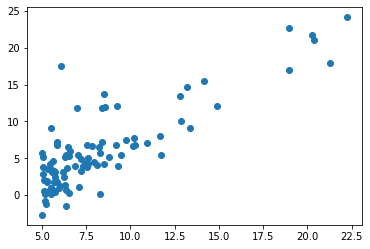

In [22]:
X,y = loaddata()
plt.scatter(X,y)

**定义第一棵树（最大深度设置为5）并进行训练**

In [23]:
tree_reg1 = DecisionTreeRegressor(max_depth=5)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=5)

**计算残差，并把残差当做目标值训练第二棵树（最大深度设定为5）**

In [24]:
y2 = y-tree_reg1.predict(X).reshape(-1,1)
tree_reg2 = DecisionTreeRegressor(max_depth=5)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=5)

**继续计算残差，并把残差当做目标值训练第三棵树（最大深度设定为5）**

In [25]:
y3 = y2-tree_reg2.predict(X).reshape(-1,1)
tree_reg3 = DecisionTreeRegressor(max_depth=5)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=5)

**取训练集前5条数据，并对前5条数据做预测**

In [26]:
X_new = X[0:5,:]
y_pred = tree_reg1.predict(X_new)+tree_reg2.predict(X_new)+tree_reg3.predict(X_new)
print(y_pred)

[17.61560196  9.15380196 12.831       4.57199973  6.68971688]


**直接使用sklearn提供的GradientBoostingRegressor**

In [27]:
gbdt = GradientBoostingRegressor(
    max_depth=5,
    n_estimators=3,
    learning_rate=1.0
)
gbdt.fit(X,y)
print(gbdt.predict(X_new))

[17.61560196  9.15380196 12.831       4.57199973  6.68971688]


D:\Anaconda3\lib\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### GBDT梯度提升树

GBDT：其关键是利用**损失函数的负梯度**作为提升树算法中要拟合的值。  

对于平方损失拟合的就是残差值，对于非平方损失拟合的就是负梯度值。提升树是梯度提升树的一个特例，拟合的是平方损失时就是提升树。  

上例中我们用的是平方损失：

$$L(y,f_t(x))=\frac{1}{2}(y-f_t(x))^2$$  

其负梯度为：  

$$-\frac{\partial L(y,f_t(x))}{\partial f_t(x)}=y=f_t(x)$$  

该负梯度就是我们之前给出的残差。

## XGBoost

<img src="img/xgboost.png" width="500">  

* $q$ 表示树结构，即 $tree1,tree2$，它把每一个样本点x映射到某一个叶子节点
* $T$ 是叶子节点的数量，对于 $tree1$ ，$T=3$；对于 $tree2$ ，$T=2$
* $w$ 是叶子节点的权值，实际就是预测值
* $f_k$ 表示第 $k$ 个树，该树的结构由 $q$ 表示，预测值由 $w$ 表示

$$\hat y_i =\phi(x_i)=\sum_{k=1}^K f_k(x_i),f_k \in \mathcal{F} \\
\mathcal F = \{f(x)=w_{q(x)}\}(q:\mathbb R^m \rightarrow T,w \in \mathbb R^T$$

### 损失函数

假设损失函数是平方损失，则初值可取所有样本的平均数  

$$\begin{align}
&\hat y_i^{(0)}=\mu \\
&\hat y_i^{(1)}=f_1(x_i)=\hat y_i^{(0)}+f_1(x_i) \\
&\hat y_i^{(2)}=f_1(x_i)+f_2(x_i)=\hat y_i^{(1)}+f_2(x_i) \\
&\hat y_i^{(3)}=f_1(x_i)+f_2(x_i)+f_3(x_i)=\hat y_i^{(2)}+f_3(x_i) \\
&... \\
&\hat y_i^{(t)}=\sum_{k=1}^K f_k(x_i)=\hat y_i^{(k-1)}+f_k(x_i)
\end{align}$$

因此，损失函数可写为：  

$$J(f_t)=\sum_{i=1}^n L(y_i,\hat y_i^{(t-1)}+f_t(x_i))+\Omega(f_t)+C$$

$\Omega (f)$ 为正则项：

$$\Omega (f)=\gamma T+\frac{1}{2}\lambda ||w||^2$$

对于 $tree1$，$\Omega =\gamma \times 3+\frac{1}{2}\lambda\times(2^2+0.1^2+(-1)^2)$

### 求解

目标函数：  

$$J(f_t)=\sum_{i=1}^n L(y_i,\hat y_i^{(t-1)}+f_t(x_i))+\Omega(f_t)+C$$

根据 $Taylor$ 公式：  

$$f(x+\Delta x)\approx f(x)+f'(x)\Delta x+\frac{1}{2}f''(x)\Delta x^2$$  

把 $\hat y_i^{(t-1)}$ 看作 $x$，$f_t(x_i)$ 看作 $\Delta x$，令：  

$$g_i=\frac{\partial L(y_i,\hat y_i^{(t-1)})}{\partial\hat y_i^{(t-1)}} \\
h_i=\frac{\partial^2L(y_i,\hat y_i^{(t-1)})}{\partial\hat y_i^{(t-1)}}$$

得：  

$$\begin{align}
J(f_t)&\approx\sum_{i=1}^n [L(y_i,\hat y_i^{(t-1)})+g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)]+\Omega(f_t)+C \\
&=\sum_{i=1}^n [g_if_t(x_i)+\frac{1}{2}h_if_t^2(x_i)]+\Omega(f_t)+C \\
&=\sum_{i=1}^n [g_iw_{q(x_i)}+\frac{1}{2}h_iw_{q(x_i)}^2]+\gamma T+\frac{1}{2}\lambda \sum_{j=1}^T w_j^2+C \\
&=\sum_{j=1}^T [(\sum_{i \in I_j} g_i)w_j+\frac{1}{2}(\sum_{i\in I_j} h_i)w_j^2]+\gamma T+\frac{1}{2}\lambda \sum_{j=1}^T w_j^2+C \\
&=\sum_{j=1}^T [(\sum_{i \in I_j} g_i)w_j+\frac{1}{2}(\sum_{i\in I_j} h_i+\lambda)w_j^2]+\gamma T+C 
\end{align}$$

令：  

$$G_j=\sum_{i\in I_j} g_i \\
H_j=\sum_{i\in I_j} h_i$$

因此：  

$$J(f_t)=\sum_{j=1}^T [G_jw_j+\frac{1}{2}(H_j+\lambda)w_j^2]+\gamma T+C $$

对 $w$ 求偏导：  

$$\frac{\partial J(f_t)}{\partial w_j}=G_j+(H_j+\lambda)w_j=0\Rightarrow w_j=-\frac{G_j}{H_j+\lambda}$$

代回目标函数得：  

$$J(f_t)=-\frac{1}{2}\sum_{j=1}^T \frac{G_j^2}{H_j+\lambda}+\gamma\cdot T$$

### 树结构生成 

<img src="img/树结构生成.png" width="600">

* 构造决策树的结构：枚举可行的分割点，选择增益最大的划分。增益=未划分的损失-划分后的损失  

<img src="img/树结构生成2.png" width="500">

### 代码实现

In [28]:
import xgboost as xgb

#### 使用libsvm数据格式 

XGBoost中数据形式可以是libsvm的，libsvm作用是对稀疏特征进行优化，看个例子：

```
1 101:1.2 102:0.03 
0 1:2.1 10001:300 10002:400
0 2:1.2 1212:21 7777:2
```
每行表示一个样本，每行开头`0，1`表示标签，而后面的则是`特征索引：1`，其他未表示都是0

我们以判断蘑菇是否有毒为例子来做后续的训练。数据集来自：http://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/ ，其中蘑菇有22个属性，将这些原始的特征加工后得到126维特征，并保存为libsvm格式，标签是表示蘑菇是否有毒。

In [29]:
data_train = xgb.DMatrix("data/agaricus.txt.train")
data_test = xgb.DMatrix("data/agaricus.txt.test")

**设置参数**  

 - eta：可看成学习率learning_rate。典型值一般设置为：0.01-0.2
 - gamma：分裂节点时，损失函数减小值只有大于等于gamma才分裂，gamma值越大，算法越保守，越不容易过拟合，但性能就不一定能保证，需要平衡。
 - objective
    - reg:linear：线性回归

    - reg:logistic：逻辑回归

    - binary:logistic 二分类的逻辑回归，返回预测的概率

    - binary:logitraw：二分类逻辑回归，输出是逻辑为0/1的前一步的分数

    - multi:softmax：用于Xgboost 做多分类问题，需要设置num_class（分类的个数）

    - multi:softprob：和softmax一样，但是返回的是每个数据属于各个类别的概率。

    - rank:pairwise：让Xgboost 做排名任务，通过最小化(Learn to rank的一种方法)
 - max_depth：决策树最大深度
 - verbosity：0 (silent), 1 (warning), 2 (info), 3 (debug)
 
 更多参数参见：https://xgboost.readthedocs.io/en/latest/parameter.html

In [30]:
param = {'max_depth':3,'eta':0.3,'verbosity':1,'objective':'binary:logistic'}
watchlist = [(data_test,'eval'),(data_train,'train')]
n_round = 6         # 集成6棵树
model = xgb.train(
    param,
    data_train,
    num_boost_round=n_round,    # data_train中既包含X也包含y
    evals=watchlist             # 查看测试集和训练集上的错误率
)    

[0]	eval-logloss:0.45317	train-logloss:0.45224
[1]	eval-logloss:0.32412	train-logloss:0.32281
[2]	eval-logloss:0.23740	train-logloss:0.23637
[3]	eval-logloss:0.16935	train-logloss:0.16932
[4]	eval-logloss:0.12352	train-logloss:0.12386
[5]	eval-logloss:0.09361	train-logloss:0.09491


**计算准确率**

In [31]:
#预测概率
y_hat = model.predict(data_test)
#把概率转换为0,1分类
y_pred = y_hat.copy()
y_pred[y_pred>=0.5]=1
y_pred[y_pred<0.5]=0
#获取实际标签
y = data_test.get_label() 

In [32]:
from sklearn.metrics import accuracy_score

print('accuracy_score=',accuracy_score(y,y_pred))

accuracy_score= 1.0


**画图**

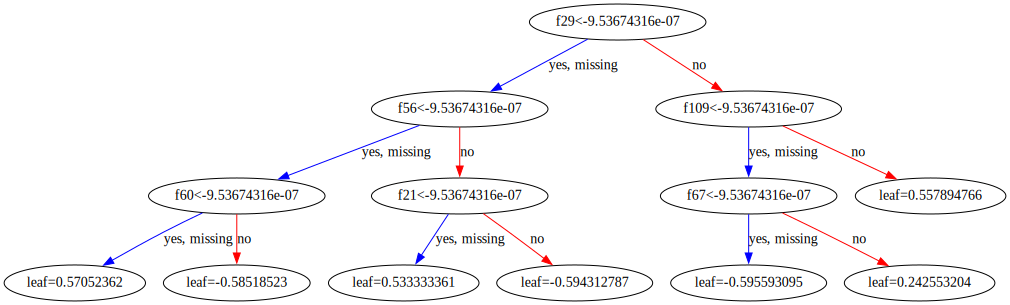

In [33]:
from matplotlib import pyplot
import graphviz

xgb.to_graphviz(model, num_trees=0 )

#### 使用sklearn加载数组

In [34]:
from sklearn.datasets import load_svmlight_file

X_train,y_train = load_svmlight_file("data/agaricus.txt.train")
X_test,y_test = load_svmlight_file("data/agaricus.txt.test")

In [35]:
type(X_train)

scipy.sparse.csr.csr_matrix

In [36]:
X_train.toarray()

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [37]:
type(y_train)

numpy.ndarray

**训练模型**

In [38]:
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.3,
    n_estimators=6,
    verbosity=1,
    objective='binary:logistic'
)
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=6, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

**计算准确率**

In [39]:
train_pred = model.predict(X_train)   # 预测结果是0，1值
train_acc = accuracy_score(y_train,train_pred)
print ("Train Accuary: %.2f%%" % (train_acc * 100.0))

Train Accuary: 99.88%


In [40]:
test_pred = model.predict(X_test)
test_acc = accuracy_score(y_test,test_pred)
print("Test Accuracy: %.2f%%" % (test_acc * 100.0))

Test Accuracy: 100.00%


#### GridSearchcv 搜索最优参数

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
model = xgb.XGBClassifier(learning_rate=0.1,verbosity=1,objective='binary:logistic')    # 不需要调的参数直接定义
# 需要调的参数
param_grid = {
    'n_estimators':range(1,51,1),
    'max_depth':range(1,10,1)
}
clf = GridSearchCV(model,param_grid,scoring="accuracy",cv=5)   # 评价指标为精确度，5折交叉验证
clf.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': range(1, 10),
                         'n_estimators': range(1, 51)},
             scoring='accuracy')

In [45]:
clf.best_params_, clf.best_score_

({'max_depth': 2, 'n_estimators': 30}, 0.9841860859908541)

#### early-stop

我们设置验证valid集，当我们迭代过程中发现在验证集上错误率增加，则提前停止迭代。

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
X_train,X_validate,y_train,y_validate = train_test_split(X_train,y_train,test_size=0.3,random_state=2)

In [48]:
# 设置boosting迭代计算次数
num_round = 100
bst = xgb.XGBClassifier(max_depth=2,learning_rate=0.1,n_estimators=num_round,verbosity=1,objective='binary:logistic')
eval_set = [(X_validate,y_validate)]   # 验证集
# 度量指标为错误率，连续10轮错误率增加则停止
bst.fit(X_train,y_train,early_stopping_rounds=10,eval_metric="error",eval_set=eval_set,verbose=True)    

[0]	validation_0-error:0.04759
[1]	validation_0-error:0.04350
[2]	validation_0-error:0.04759
[3]	validation_0-error:0.04350
[4]	validation_0-error:0.04350
[5]	validation_0-error:0.04350
[6]	validation_0-error:0.04350
[7]	validation_0-error:0.02508
[8]	validation_0-error:0.04350
[9]	validation_0-error:0.02508
[10]	validation_0-error:0.00563
[11]	validation_0-error:0.00563
[12]	validation_0-error:0.01024
[13]	validation_0-error:0.01535
[14]	validation_0-error:0.01535
[15]	validation_0-error:0.01535
[16]	validation_0-error:0.01535
[17]	validation_0-error:0.01535
[18]	validation_0-error:0.02661
[19]	validation_0-error:0.02303


D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
D:\Anaconda3\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [49]:
results = bst.evals_result()
results

{'validation_0': OrderedDict([('error',
               [0.04759467758444217,
                0.04350051177072672,
                0.04759467758444217,
                0.04350051177072672,
                0.04350051177072672,
                0.04350051177072672,
                0.04350051177072672,
                0.02507676560900717,
                0.04350051177072672,
                0.02507676560900717,
                0.00562947799385875,
                0.00562947799385875,
                0.01023541453428864,
                0.01535312180143296,
                0.01535312180143296,
                0.01535312180143296,
                0.01535312180143296,
                0.01535312180143296,
                0.02661207778915046,
                0.02302968270214944,
                0.02302968270214944])])}

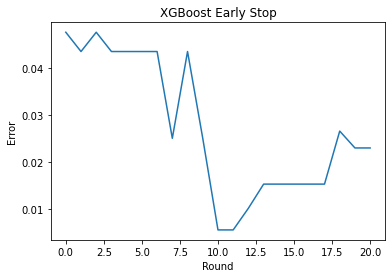

In [50]:
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
plt.plot(x_axis, results['validation_0']['error'], label='Test')
plt.ylabel('Error')
plt.xlabel('Round')
plt.title('XGBoost Early Stop')
plt.show()

#### 学习曲线

In [51]:
# 设置boosting迭代计算次数
num_round = 100
# 没有 eraly_stop
bst = xgb.XGBClassifier(max_depth=2, learning_rate=0.1, n_estimators=num_round, verbosity=1, objective='binary:logistic')
# 在训练集和验证集上进行评价 
eval_set = [(X_train, y_train), (X_validate, y_validate)]
bst.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)    # 评价指标为错误率和损失

[0]	validation_0-error:0.04606	validation_0-logloss:0.61481	validation_1-error:0.04759	validation_1-logloss:0.61499
[1]	validation_0-error:0.04080	validation_0-logloss:0.55010	validation_1-error:0.04350	validation_1-logloss:0.55056
[2]	validation_0-error:0.04606	validation_0-logloss:0.49576	validation_1-error:0.04759	validation_1-logloss:0.49635
[3]	validation_0-error:0.04080	validation_0-logloss:0.44943	validation_1-error:0.04350	validation_1-logloss:0.45021
[4]	validation_0-error:0.04080	validation_0-logloss:0.40961	validation_1-error:0.04350	validation_1-logloss:0.41164
[5]	validation_0-error:0.04080	validation_0-logloss:0.37398	validation_1-error:0.04350	validation_1-logloss:0.37501
[6]	validation_0-error:0.04080	validation_0-logloss:0.34328	validation_1-error:0.04350	validation_1-logloss:0.34471
[7]	validation_0-error:0.02391	validation_0-logloss:0.31609	validation_1-error:0.02508	validation_1-logloss:0.31817
[8]	validation_0-error:0.04080	validation_0-logloss:0.29136	validation_1

[71]	validation_0-error:0.00197	validation_0-logloss:0.02512	validation_1-error:0.00205	validation_1-logloss:0.02635
[72]	validation_0-error:0.00197	validation_0-logloss:0.02458	validation_1-error:0.00205	validation_1-logloss:0.02582
[73]	validation_0-error:0.00197	validation_0-logloss:0.02407	validation_1-error:0.00205	validation_1-logloss:0.02534
[74]	validation_0-error:0.00197	validation_0-logloss:0.02356	validation_1-error:0.00205	validation_1-logloss:0.02466
[75]	validation_0-error:0.00197	validation_0-logloss:0.02307	validation_1-error:0.00205	validation_1-logloss:0.02421
[76]	validation_0-error:0.00197	validation_0-logloss:0.02259	validation_1-error:0.00205	validation_1-logloss:0.02373
[77]	validation_0-error:0.00197	validation_0-logloss:0.02213	validation_1-error:0.00205	validation_1-logloss:0.02328
[78]	validation_0-error:0.00197	validation_0-logloss:0.02167	validation_1-error:0.00205	validation_1-logloss:0.02270
[79]	validation_0-error:0.00197	validation_0-logloss:0.02120	val

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [52]:
results = bst.evals_result()
results

{'validation_0': OrderedDict([('error',
               [0.04606273305549462,
                0.04079842070629524,
                0.04606273305549462,
                0.04079842070629524,
                0.04079842070629524,
                0.04079842070629524,
                0.04079842070629524,
                0.02390875191928054,
                0.04079842070629524,
                0.02390875191928054,
                0.00614169774073262,
                0.00614169774073262,
                0.01206404913358193,
                0.01820574687431454,
                0.01820574687431454,
                0.01820574687431454,
                0.01820574687431454,
                0.01820574687431454,
                0.02500548365869708,
                0.02083790304891424,
                0.02083790304891424,
                0.02083790304891424,
                0.02083790304891424,
                0.02083790304891424,
                0.02083790304891424,
                0.02083790304891424

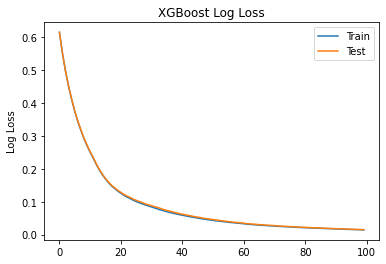

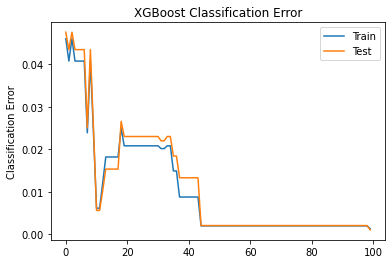

In [53]:
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

# plot classification error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('Classification Error')
plt.title('XGBoost Classification Error')
plt.show()

# 堆叠Stacking

## 原理

<img src="img/stacking.png" width="900">

## 代码实现

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

In [55]:
data = np.loadtxt("data/wine.data",delimiter=',')
X = data[:,1:]
y = data[:,0:1]
X_train, X_test, y_train, y_test = train_test_split(X, y.ravel(), test_size=0.2, random_state=0)

**定义基分类器**

In [56]:
clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

**定义最后用的逻辑回归分类器**

In [57]:
lr = LogisticRegression()

**定义堆叠集成**

In [58]:
sclf = StackingClassifier(classifiers=[clf1,clf2,clf3],meta_classifier=lr,use_probas=True)    # 使用概率输出

**对每一个模型分别进行评价**

In [59]:
for model in [clf1,clf2,clf3,sclf]:
    model.fit(X_train,y_train)
    y_test_hat = model.predict(X_test)
    print(model.__class__.__name__,',test accuarcy:',accuracy_score(y_test,y_test_hat))

KNeighborsClassifier ,test accuarcy: 0.8055555555555556
RandomForestClassifier ,test accuarcy: 1.0
GaussianNB ,test accuarcy: 0.9166666666666666
StackingClassifier ,test accuarcy: 0.9722222222222222
